# IMPORTS

In [ ]:
# IMPORTS
import itertools as it
import math

import matplotlib

# matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from graphviz import Digraph
from openai import OpenAI

# matplotlib.use("Qt5Agg")
dtype = torch.float
device = torch.device("cpu")

# Utility code

In [ ]:
# Function for plotting multi-graphs
# See https://networkx.org/documentation/stable/auto_examples/drawing/plot_multigraphs.html
def draw_labeled_multigraph(G, attr_name, ax=None):
    """
    Length of connectionstyle must be at least that of a maximum number of edges
    between pair of nodes. This number is maximum one-sided connections
    for directed graph and maximum total connections for undirected graph.
    """
    # Works with arc3 and angle3 connectionstyles
    connectionstyle = [f"arc3,rad={r}" for r in it.accumulate([0.15] * 4)]
    # connectionstyle = [f"angle3,angleA={r}" for r in it.accumulate([30] * 4)]

    pos = nx.shell_layout(G)
    nx.draw_networkx_nodes(G, pos, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=20, ax=ax)
    nx.draw_networkx_edges(
        G, pos, edge_color="grey", connectionstyle=connectionstyle, ax=ax
    )

    labels = {
        tuple(edge): f"{attr_name}={attrs[attr_name]}"
        for *edge, attrs in G.edges(keys=True, data=True)
    }
    nx.draw_networkx_edge_labels(
        G,
        pos,
        labels,
        connectionstyle=connectionstyle,
        label_pos=0.3,
        font_color="blue",
        bbox={"alpha": 0},
        ax=ax,
    )
    return connectionstyle

# Create the graph

In [ ]:
# Multigraph with one multiple edge

G = nx.MultiDiGraph()
G.add_edges_from([("x1", "x3"), ("x1", "x3"), ("x2", "x3"), ("x3", "x4")])

In [ ]:
# We'll be using a multi-graph, though our first example won't have any multiple edges

G = nx.MultiDiGraph()
G.add_edges_from([("x1", "x3"), ("x2", "x3"), ("x3", "x4")])

G.add_edge("x", "h")  # edge 0
G.add_edge("x", "h")  # edge 1 (parallel edge)
G.add_edge("h", "y")

G.add_edges_from([("x1", "h"), ("x2", "h"), ("h", "y")])

node_dims = {
    "x": 4,
    "h": 8,
    "y": 2,
}

# model = DAGModule(G, node_dims)
# x = torch.randn(16, 4)
# out = model({"x": x})
# print(out["y"].shape)  # (16, 2)

# Plot the graph

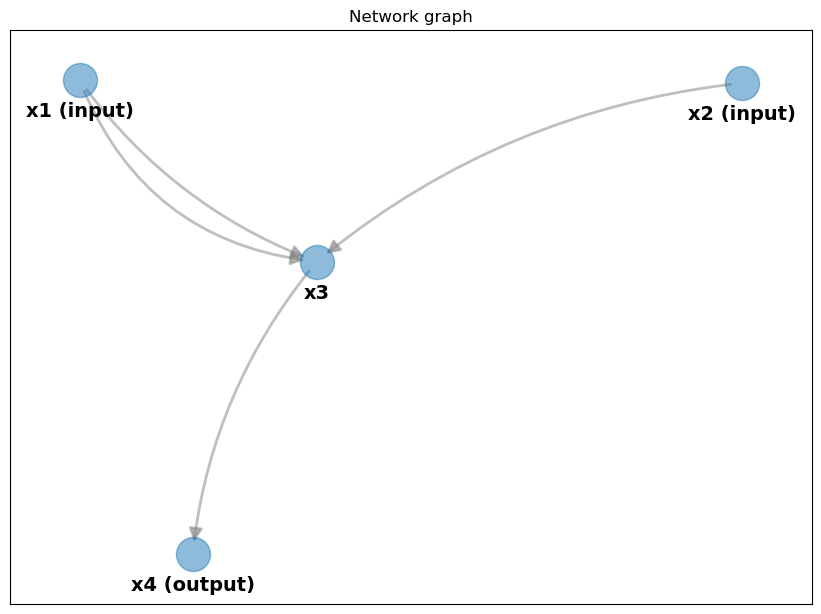

In [60]:
connectionstyle = [f"arc3,rad={r}" for r in it.accumulate([0.15] * 4)]
# connectionstyle = [f"angle3,angleA={r}" for r in it.accumulate([30] * 4)]

fig, axes = plt.subplots(1, 1)

# pos = nx.shell_layout(G)
pos = nx.spring_layout(G, seed=7)

input_nodes = [n for n in G.nodes() if G.in_degree(n) == 0]
output_nodes = [n for n in G.nodes() if G.out_degree(n) == 0]
labels = {n: n for n in G}
for i in input_nodes:
    labels[i] = labels[i] + " (input)"
for i in output_nodes:
    labels[i] = labels[i] + " (output)"
for i in labels:
    labels[i] = "\n" + labels[i]

nx.draw_networkx_nodes(G, pos, ax=axes, node_size=600, alpha=0.5)
nx.draw_networkx_labels(
    G,
    pos,
    font_size=14,
    ax=axes,
    labels=labels,
    verticalalignment="top",
    font_weight="bold",
)
nx.draw_networkx_edges(
    G,
    pos,
    edge_color="grey",
    connectionstyle=connectionstyle,
    ax=axes,
    arrowsize=20,
    width=2.0,
    alpha=0.5,
)
# plt.title("Network graph")
axes.set_title("Network graph")
fig.tight_layout(rect=(0, 0, 1.3, 1.3))
plt.show()

# Create the network

In [ ]:
# MULTIGRAPH VERSION


class DAGModule(nn.Module):
    def __init__(
        self,
        graph: nx.MultiDiGraph,
        node_dims: dict,
        input_nodes=None,
        output_nodes=None,
        nonlinearity=nn.ReLU(),
    ):
        """
        graph: networkx.MultiDiGraph (must be acyclic)
        node_dims: dict {node_name: feature_dimension}
        input_nodes: optional list of input node names
        output_nodes: optional list of output node names
        """

        super().__init__()

        if not isinstance(graph, nx.MultiDiGraph):
            raise TypeError("graph must be a networkx.MultiDiGraph")

        if not nx.is_directed_acyclic_graph(graph):
            raise ValueError("Graph must be acyclic.")

        self.graph = graph.copy()
        self.node_dims = node_dims
        self.f = nonlinearity

        # Determine sources and sinks if not specified
        if input_nodes is None:
            input_nodes = [
                n for n in self.graph.nodes() if self.graph.in_degree(n) == 0
            ]

        if output_nodes is None:
            output_nodes = [
                n for n in self.graph.nodes() if self.graph.out_degree(n) == 0
            ]

        if len(input_nodes) == 0:
            raise ValueError("No input nodes found (no sources).")

        if len(output_nodes) == 0:
            raise ValueError("No output nodes found (no sinks).")

        self.input_nodes = input_nodes
        self.output_nodes = output_nodes

        # Topological order
        self.topo_order = list(nx.topological_sort(self.graph))

        # One linear map per edge (u, v, key)
        self.edge_maps = nn.ModuleDict()
        for u, v, k in self.graph.edges(keys=True):
            edge_id = self._edge_id(u, v, k)
            self.edge_maps[edge_id] = nn.Linear(
                node_dims[u],
                node_dims[v],
                bias=False,
            )

        # Bias per non-input node
        self.node_biases = nn.ParameterDict()
        for node in self.graph.nodes():
            if node not in self.input_nodes:
                self.node_biases[node] = nn.Parameter(
                    torch.zeros(node_dims[node]))

    def _edge_id(self, u, v, k):
        return f"{u}->{v}::{k}"

    def forward(self, inputs: dict):
        """
        inputs: dict {node_name: tensor (batch_size, node_dims[node])}
        returns: dict {output_node: tensor}
        """

        values = {}

        # Ensure required inputs are provided
        for node in self.input_nodes:
            if node not in inputs:
                raise ValueError(f"Missing input for node '{node}'")

        for node in self.topo_order:

            if node in self.input_nodes:
                values[node] = inputs[node]

            else:
                total = 0

                # iterate over incoming edges including multiplicities
                for u, _, k in self.graph.in_edges(node, keys=True):
                    edge_id = self._edge_id(u, node, k)
                    total = total + self.edge_maps[edge_id](values[u])

                total = total + self.node_biases[node]
                values[node] = self.f(total)

        # Return dict keyed by output node names
        return {node: values[node] for node in self.output_nodes}

# Create the input/output data

In [ ]:
# number of data points
N = 2000

# input data x
x = torch.zeros((N, 1))
x[:, 0] = torch.linspace(-math.pi, math.pi, N)

# output data y
y = torch.sin(x)


# PLOT THE DATA
# plt.plot(x, y, "ro")
# plt.xlabel("input")
# plt.ylabel("output")
# plt.title("function to learn")
# plt.show()

In [ ]:
# PLOT THE LEARNED CURVE
xplot = x.detach().numpy()
yplot = y.detach().numpy()
yFinal = model(x)
yFinalplot = yFinal.detach().numpy()

plt.figure()
plt.plot(xplot, yplot, "ro", label="Data")
plt.plot(xplot, yFinalplot, label="Final model")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Two Curves on the Same Axes")
plt.legend()
plt.grid(False)

plt.show()

# Create the network

In [ ]:
# "node_dims" is a dictionary; the keys are strings giving the name of a node, and the value is a positive integer (the
# dimension)
node_dims = {"x1": 4, "x2": 4, "h": 8, "y": 2}
model = DAGModule(G, node_dims)
x1 = torch.randn(32, 4)
x2 = torch.randn(32, 4)
out = model({"x1": x1, "x2": x2})
print(out["y"].shape)  # (32, 2)

# Optimize the network

In [ ]:
input_size = 1
output_size = 1
# hidden_size = 2
hidden_size = 10

# Create the module
model = NeuralNet(input_size, hidden_size, output_size)

# FOR DEBUGGING:
# - PRINT MODEL PARAMETERS AND SIZES
# for name, param in model.named_parameters():
#     print(name, type(param), param.size())
# - TEST SHAPE AGREEMENT
# apply the initialized model to the data
# out_initial = model(x)
# print(y.size())
# print(out_initial.size())

# TRAIN THE NETWORK
# Choose the loss function
criterion = nn.MSELoss()

# Optimization algorithm
# Choose the optimization algorithm. To start with we'll use vanilla gradient descent (which also means we'll evaluate the full data set on every optimization step)

# Learning rate
# Quick Learning rate choice procedure:
# - TODO: Should really: compute the MSE of (model_0(x)-y), and divide (or ... ? need to figure this out) by the norm of
#  the initial gradient
# - For now I'll just use MSE((model_0(x)-y)), as if the norm of the initial gradient was 1. Can also pre-multiply by
# some number to "be safe"
n_steps = 100
y_diff = criterion(model(x), y)
learning_rate = y_diff / n_steps
n_steps = n_steps * 100
# Create optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
for i in range(n_steps):
    # Forward pass
    y_i = model(x)
    loss = criterion(y_i, y)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i + 1) % (n_steps / 10) == 0:
        print("Step [{}/{}], Loss: {:.4f}".format(i + 1, n_steps, loss.item()))